## Basic Fine-Tuning -> BERT-based text classification pipeline using a benchmark dataset.

# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Load the dataset

In [2]:
# Load dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

# Encode labels (ham=0, spam=1)
df["label"] = df["label"].map({"ham": 0, "spam": 1})

df.head()


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Data preprocessing - Data imbalance issue

In [3]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [4]:
747/4825

0.15481865284974095

In [5]:
df_ham = df[df['label']== 0]
df_ham.shape

(4825, 2)

In [6]:
df_spam = df[df['label']== 1 ]
df_spam.shape

(747, 2)

In [7]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [8]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['label'].value_counts()

,count
label,
0,747
1,747


In [ ]:
df_balanced.sample(5)

,label,text
3132,1,LookAtMe!: Thanks for your purchase of a video...
1820,0,Dunno dat's wat he told me. Ok lor...
4906,1,Warner Village 83118 C Colin Farrell in SWAT t...
794,0,Omg I want to scream. I weighed myself and I l...
2850,1,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...


# Splitting the dataset - Train & Test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["text"].values,
    df_balanced["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=df_balanced["label"]
)


In [10]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

1195 299 1195 299


# Bert Tokenization - Take the dataset and token them using bert base model

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 128

def bert_tokenize(texts):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )

train_encodings = bert_tokenize(X_train)
test_encodings = bert_tokenize(X_test)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


# Review the tokenization - Input IDs and Attention mask

In [15]:
print(X_train)
print(len(X_train))

['You are a winner U have been specially selected 2 receive £1000 cash or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810810'
 'Welcome to Select, an O2 service with added benefits. You can now call our specially trained advisors FREE from your mobile by dialling 402.'
 "But that's on ebay it might be less elsewhere." ...
 'sports fans - get the latest sports news str* 2 ur mobile 1 wk FREE PLUS a FREE TONE Txt SPORT ON to 8007 www.getzed.co.uk 0870141701216+ norm 4txt/120p '
 'How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?'
 'Hi. Wk been ok - on hols now! Yes on for a bit of a run. Forgot that i have hairdressers appointment at four so need to get home n shower beforehand. Does that cause prob for u?"']
[1 1 0 ... 1 1 0]
1195


In [ ]:
print(train_encodings)

{'input_ids': <tf.Tensor: shape=(1195, 128), dtype=int32, numpy=
array([[ 101, 2017, 2024, ...,    0,    0,    0],
       [ 101, 6160, 2000, ...,    0,    0,    0],
       [ 101, 2001, 2725, ...,    0,    0,    0],
       ...,
       [ 101, 2998, 4599, ...,    0,    0,    0],
       [ 101, 2129, 2272, ...,    0,    0,    0],
       [ 101, 1045, 1059, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1195, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1195, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
print(X_train[0])

You are a winner U have been specially selected 2 receive £1000 cash or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810810


In [ ]:
print(train_encodings['input_ids'][0])

tf.Tensor(
[  101  2017  2024  1037  3453  1057  2031  2042 11974  3479  1016  4374
 27708  2692  5356  2030  1037  1018  1008  6209  1006  7599  4297  1007
  3713  2000  1037  2444  6872  1016  4366  5511  2581 12521  2581  2581
  2620 10790  2620 10790   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


In [ ]:
print(train_encodings['attention_mask'][0])

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int32)


# Initializating the BERT Model

In [ ]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

# Initializating the Fully connected layer and providing the BERT Embeddings to it

In [ ]:
# how tokenized text enters the neural network, telling Keras that each training example consists of two sequences of integers:
input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_output = bert_model(
    input_ids,
    attention_mask=attention_mask
)

# CLS token embedding -> (batch_size, sequence_length, hidden_size)  -> (32, 0, 768)
# [:, 0, :]  -> [Take all the samples, [CLS] Token (where it'll be having the entire sentence information), All the embeddings]
cls_embedding = bert_output.last_hidden_state[:, 0, :]

x = tf.keras.layers.Dense(128, activation="relu")(cls_embedding)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(
    inputs=[input_ids, attention_mask],
    outputs=output
)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

Jus to heads-up!!!

Number of parameters = (input_units × output_units) + output_units


98432 parameters = (768 × 128) + 128


In [ ]:
#Each sentence length is 128 and embedding shape of each sentence is 768
print(bert_output.last_hidden_state.shape)
print(cls_embedding.shape)

(None, 128, 768)
(None, 768)


In [ ]:
print(bert_output.pooler_output.shape)

(None, 768)


# Manual way to check the Bert Embedding flow

In [ ]:
text = "500$ discount. hurry up"

text_encoding = bert_tokenize([text])

print(text_encoding)

bert_output = bert_model(
    text_encoding["input_ids"],
    attention_mask=text_encoding["attention_mask"]
)

print(bert_output)

{'input_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  3156,  1002, 19575,  1012,  9241,  2039,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

# Compiling the BERT + FC model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


# Train the model with validation split

In [ ]:
history = model.fit(
    x={
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    y=y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=16
)


Epoch 1/3


68/68 [==============================] - 83s 489ms/step - loss: 0.1729 - accuracy: 0.9302 - val_loss: 0.1089 - val_accuracy: 0.9750
Epoch 2/3
68/68 [==============================] - 30s 435ms/step - loss: 0.0328 - accuracy: 0.9898 - val_loss: 0.1107 - val_accuracy: 0.9750
Epoch 3/3
68/68 [==============================] - 29s 430ms/step - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.1424 - val_accuracy: 0.9750


83s 490ms/step - loss: 0.1486 - accuracy: 0.9479 - val_loss: 0.1458 - val_accuracy: 0.9583


val_loss ≫ loss → overfitting  

val_loss < loss → healthy training

validation accuracy and model accuracy almost equal (0.9963 ~ 0.9750), so model is good in generalization.

# Evaluating the model with accuracy, confusion matrix and classification matrix

In [ ]:
test_loss, test_acc = model.evaluate(
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"]
    },
    y_test
)

print("Test Accuracy:", test_acc)


10/10 [==============================] - 3s 260ms/step - loss: 0.0835 - accuracy: 0.9799
Test Accuracy: 0.9799330830574036


In [ ]:
y_pred_prob = model.predict(
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }
)

y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


10/10 [==============================] - 5s 252ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       0.99      0.97      0.98       149

    accuracy                           0.98       299
   macro avg       0.98      0.98      0.98       299
weighted avg       0.98      0.98      0.98       299

[[149   1]
 [  5 144]]


Text(50.722222222222214, 0.5, 'Truth')

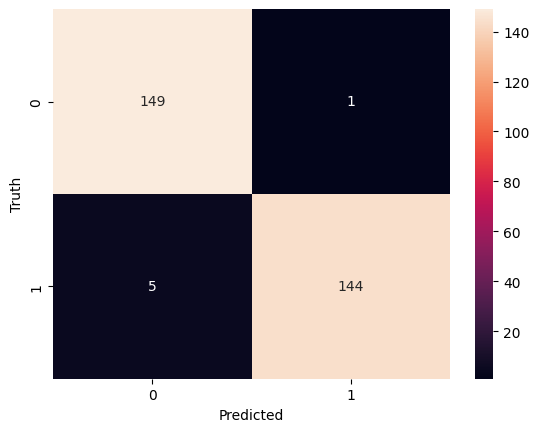

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Manual predictions -

In [ ]:
def predict_text(texts, model, tokenizer, max_len=128):
    """
    texts: list of strings
    returns: predicted class and confidence
    """
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

    probs = model.predict({
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    })

    preds = (probs > 0.5).astype(int)

    return preds, probs


In [ ]:
label_map = {
    0: "HAM (Not Spam)",
    1: "SPAM"
}

manual_texts = [
    "Hey, are we meeting today?",
    "You won $1000 cash prize, call immediately!",
    "Please find the attached project report",
    "Limited offer!!! Claim your reward now"
]

preds, probs = predict_text(manual_texts, model, tokenizer)

for text, p, pr in zip(manual_texts, preds, probs):
    print("-" * 60)
    print("Text:", text)
    print("Prediction:", label_map[int(p[0])])
    print("Confidence:", round(float(pr[0]), 4))


1/1 [==============================] - 0s 59ms/step
------------------------------------------------------------
Text: Hey, are we meeting today?
Prediction: HAM (Not Spam)
Confidence: 0.0004
------------------------------------------------------------
Text: You won $1000 cash prize, call immediately!
Prediction: SPAM
Confidence: 0.977
------------------------------------------------------------
Text: Please find the attached project report
Prediction: HAM (Not Spam)
Confidence: 0.409
------------------------------------------------------------
Text: Limited offer!!! Claim your reward now
Prediction: HAM (Not Spam)
Confidence: 0.0439
